In [79]:
using 
CSV,
Dates,
DataFrames,
Markdown,
Plots,
Statistics,
StatsPlots

In [80]:
death_path = "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
confirmed_path = "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
;

In [81]:
death = CSV.read(death_path) |> DataFrame! |> x -> rename!(x, Dict(Symbol("Province/State") => :state, Symbol("Country/Region") => :country))
confirmed = CSV.read(confirmed_path) |> DataFrame! |> x -> rename!(x, Dict(Symbol("Province/State") => :state, Symbol("Country/Region") => :country))
;

In [82]:
"""
    convert an array of columns and column names into a markdown table

    parameters: 
        cols : Array[Array[Any]] | DataFrame
            an array of arrays which are the columns of the table
        names : Array[String]
            an array of column names. If inputting a df, input `string.(names(df))`
        df : Boolean
            whether or not the cols are an array of arrays or a dataframe

    returns: String
        string of markdown text
"""
function markdown_table(cols, names; df=false)
    if df
        cols = [col for col in eachcol(cols)]
    end
    output_string = ""
    cols = [repr.(col) for col in cols]
    for i in 1:length(names)
        output_string = output_string * "|" * names[i]
    end
    output_string *= "\n"
    for i in 1:length(names)
        output_string = output_string * "|" * "---"
    end
    output_string *= "\n"
    for row in 1:length(cols[1])
        for col in 1:length(cols)
            output_string = output_string * "|" * cols[col][row]
        end
        output_string *= "\n"
    end
    # displaying strings without quotes
    output_string =  replace(output_string, "\"" => "")

    return output_string
end
;

In [83]:
function country_data(country; state=false, start_date=Dates.Date(2020, 1, 22), end_date="max")
    aggregate(x) = [sum(col) for col in eachcol(x)]
    
    state_mask = typeof(state) == String ? death.state .== state : true
    d = death[(death.country .== country) .& state_mask, 5:end] |> aggregate
    dates = [Dates.Date(2020, 1, 22) + Dates.Day(day) for day in 1:length(d)] |> x -> reshape(x, :, 1)
    state_mask = typeof(state) == String ? confirmed.state .== state : true
    c = confirmed[(confirmed.country .== country) .& state_mask, 5:end] |> aggregate
    
    df = convert(DataFrame, dates) |> x -> rename!(x, [:date])
    country_name = typeof(state) == String ? country * "-" * state : country
    df[!, :country] .= country_name
    df[!, :confirmed] = c
    df[!, :deaths] = d
    df[!, :death_rate] = d ./ c
    df[!, :new_cases] .= 0
    df[2:end, :new_cases] = df[2:end, :confirmed] .- df[1:end-1, :confirmed]
    df[!, :new_deaths] .= 0
    df[2:end, :new_deaths] = df[2:end, :deaths] .- df[1:end-1, :deaths]
    df[!, :acceleration_cases] .= 0
    df[2:end, :acceleration_cases] = df[2:end, :new_cases] .- df[1:end-1, :new_cases]
    df[!, :acceleration_deaths] .= 0
    df[2:end, :acceleration_deaths] = df[2:end, :new_deaths] .- df[1:end-1, :new_deaths]
    df[!, :days_since_100] .= 0
    counter = 0
    for row in eachrow(df)
        if row.confirmed > 100
            counter += 1
        end
        row.days_since_100 = counter
    end
    
    if end_date == "max"
        end_date = maximum(df.date)
    end
    return df[(df.date .>= start_date) .& (df.date .<= end_date), :]
end
;

In [84]:
function plot_country(country; state=false, metric=:confirmed, start_date=Dates.Date(2020, 1, 22), end_date="max", days_since_100=false)
    data = country_data(country; state=state, start_date=start_date, end_date=end_date)
    if days_since_100
        plot(data[data.days_since_100 .> 0, :days_since_100], data[data.days_since_100 .> 0, metric], label=country * ": "* String(metric), legend=:outertopright, size=(1000, 500))
    else
        plot(data.date, data[!, metric], label=country * ": "* String(metric), legend=:outertopright, size=(1000, 500))
    end
    
    plot!([0], linetype=:hline, color=:black, label="")
end
function plot_country!(country; state=false, metric=:confirmed, start_date=Dates.Date(2020, 1, 22), end_date="max", days_since_100=false)
    data = country_data(country; state=state, start_date=start_date, end_date=end_date)
    if days_since_100
        plot!(data[data.days_since_100 .> 0, :days_since_100], data[data.days_since_100 .> 0, metric], label=country * ": "* String(metric), legend=:outertopright, size=(1000, 500))
    else
        plot!(data.date, data[!, metric], label=country * ": "* String(metric), legend=:outertopright, size=(1000, 500))
    end
end
;

In [85]:
all_countries = death.country |> unique |> sort
all_country_data = vcat([country_data(country) for country in all_countries]...)
current_state = by(all_country_data, [:country], :confirmed => maximum, :deaths => maximum)
current_state[!, :death_rate] = current_state.deaths_maximum ./ current_state.confirmed_maximum
;

In [86]:
Markdown.parse("""
    # Overview of COVID-19 as of $(maximum(all_country_data.date))
    This page uses data from https://github.com/CSSEGISandData/COVID-19 (Johns Hopkins CSSE is the original source) to create a report on the status of COVID-19 cases and deaths around the world. It is updated once a day around 10:00am CET.
    """)

# Overview of COVID-19 as of 2020-03-30

This page uses data from https://github.com/CSSEGISandData/COVID-19 (Johns Hopkins CSSE is the original source) to create a report on the status of COVID-19 cases and deaths around the world. It is updated once a day around 10:00am CET.


## Worldwide Current State

In [87]:
tmp = current_state
#tmp = current_state[current_state.country .== "Hungary", :]
Markdown.parse("""
- Confirmed cases: $(sum(tmp.confirmed_maximum))
- Deaths: $(sum(tmp.deaths_maximum))
- Death Rate: $(round(sum(tmp.deaths_maximum) / sum(tmp.confirmed_maximum) * 100, digits=2))%
""")

  * Confirmed cases: 720129
  * Deaths: 33931
  * Death Rate: 4.71%


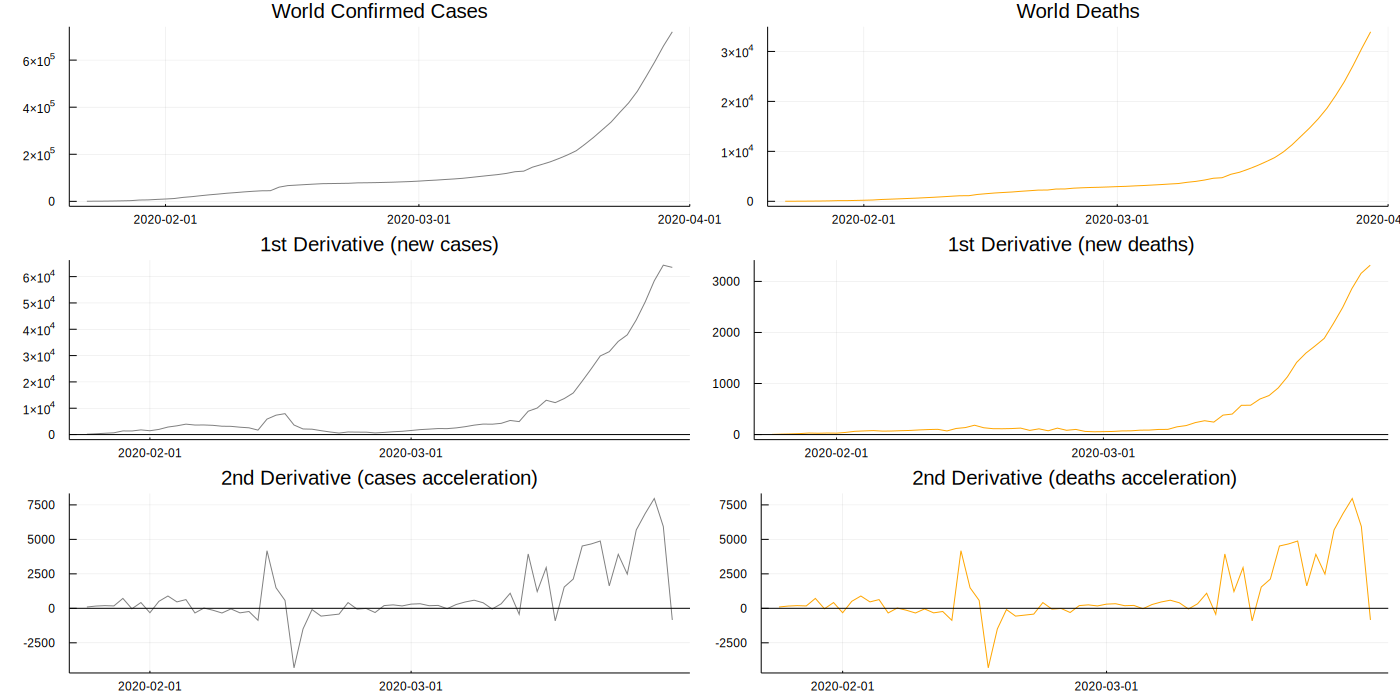

In [88]:
country_name = "World"
if country_name == "World"
    tmp = all_country_data
else
    tmp = all_country_data[all_country_data.country .== country_name, :]
end
agg = by(tmp, [:date], :confirmed => sum, :deaths => sum)
conf = plot(agg.date, agg.confirmed_sum, legend=false, title="$country_name Confirmed Cases", size=(1400, 700), color=:grey)
death_plot = plot(agg.date, agg.deaths_sum, legend=false, title="$country_name Deaths", size=(1400, 700), color=:orange)

# derivates
agg[!, :new_cases] .= 0
agg[!, :new_cases][2:end] = agg.confirmed_sum[2:end] - agg.confirmed_sum[1:end-1]
agg[!, :new_deaths] .= 0
agg[!, :new_deaths][2:end] = agg.deaths_sum[2:end] - agg.deaths_sum[1:end-1]
agg[!, :conf_acceleration] .= 0
agg[!, :conf_acceleration][2:end] = agg.new_cases[2:end] - agg.new_cases[1:end-1]
agg[!, :death_acceleration] .= 0
agg[!, :death_acceleration][2:end] = agg.new_cases[2:end] - agg.new_cases[1:end-1]

# moving average
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]
n_days = 3
ma_date = agg.date[1 + n_days-1:end]
conf_slope = moving_average(agg.new_cases, n_days)
death_slope = moving_average(agg.new_deaths, n_days)
conf_acc = moving_average(agg.conf_acceleration, n_days)
death_acc = moving_average(agg.death_acceleration, n_days)

p_conf_slope = plot(ma_date, conf_slope, legend=false, title="1st Derivative (new cases)", size=(1400, 700), color=:grey)
plot!([0], linetype=:hline, color=:black, label="")

p_death_slope = plot(ma_date, death_slope, legend=false, title="1st Derivative (new deaths)", size=(1400, 700), color=:orange)
plot!([0], linetype=:hline, color=:black, label="")

p_conf_acc = plot(ma_date, conf_acc, legend=false, title="2nd Derivative (cases acceleration)", size=(1400, 700), color=:grey)
plot!([0], linetype=:hline, color=:black, label="")

p_death_acc = plot(ma_date, death_acc, legend=false, title="2nd Derivative (deaths acceleration)", size=(1400, 700), color=:orange)
plot!([0], linetype=:hline, color=:black, label="")

plot(conf, death_plot, p_conf_slope, p_death_slope, p_conf_acc, p_death_acc, layout=(3,2))

## Top 10 Worst Affected Countries
### Confirmed

In [89]:
top_10 = sort(current_state, order(:confirmed_maximum, rev=true))[1:10, :]
top_10[!, :death_rate] = string.(round.(top_10.death_rate * 100, digits=2)) .* "%"
Markdown.parse(
    markdown_table(top_10, ["Country", "Confirmed Cases", "Deaths", "Death Rate"]; df=true)
)

|        Country | Confirmed Cases | Deaths | Death Rate |
| --------------:| ---------------:| ------:| ----------:|
|             US |          140886 |   2467 |      1.75% |
|          Italy |           97689 |  10779 |     11.03% |
|          China |           82122 |   3304 |      4.02% |
|          Spain |           80110 |   6803 |      8.49% |
|        Germany |           62095 |    533 |      0.86% |
|         France |           40708 |   2611 |      6.41% |
|           Iran |           38309 |   2640 |      6.89% |
| United Kingdom |           19780 |   1231 |      6.22% |
|    Switzerland |           14829 |    300 |      2.02% |
|    Netherlands |           10930 |    772 |      7.06% |


## Days Since 100th Case

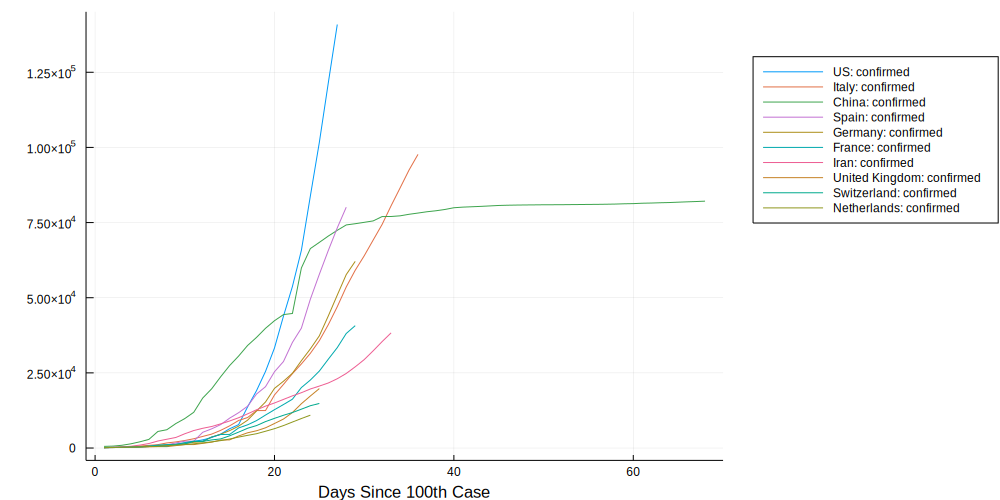

In [106]:
countries = top_10.country
fig = plot()
for country in countries
    plot_country!(country; days_since_100=true, metric=:confirmed)
end
plot!(xlabel="Days Since 100th Case")
fig

### Deaths

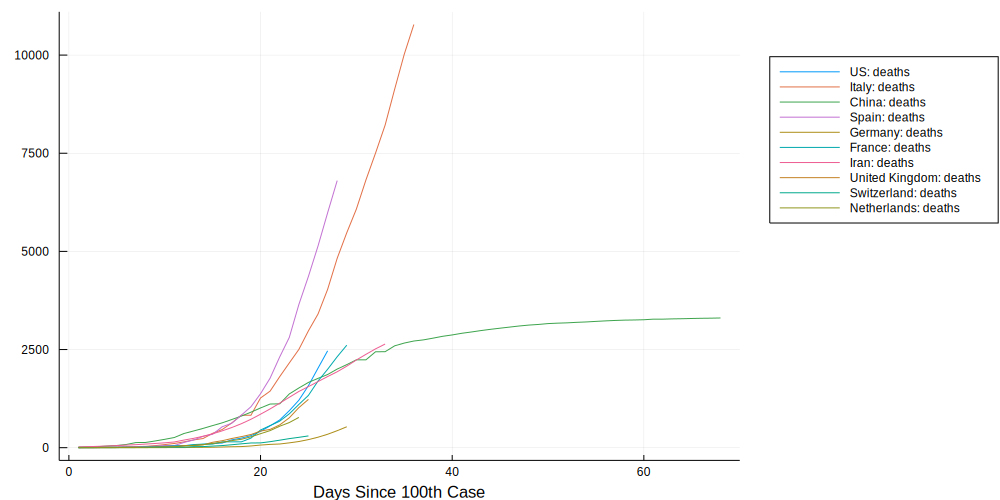

In [107]:
fig = plot()
for country in countries
    plot_country!(country; days_since_100=true, metric=:deaths)
end
plot!(xlabel="Days Since 100th Case")
fig

# Acceleration (>1000 cases now)
The `Acceleration of Last 5 Days` column is calculated by the average second derivative over the last 5 days / number of cases 5 days ago. It doesn't have much intrinsic meaning but is rather a more comparable/relative measure between countries of how fast new cases are accelerating.

In [92]:
countries = unique(all_country_data.country)
acceleration = []
cases_5_ago = []
cases_now = []
for country in countries
    metric = mean(all_country_data[all_country_data.country .== country, :acceleration_cases][end-4:end])
    metric /= all_country_data[all_country_data.country .== country, :confirmed][end-4]
    if isnan(metric)
        metric = 0
    end
    push!(acceleration, metric)
    push!(cases_5_ago, all_country_data[all_country_data.country .== country, :confirmed][end-4])
    push!(cases_now, all_country_data[all_country_data.country .== country, :confirmed][end])
end
last_5 = rename!(DataFrame([countries, acceleration, cases_now, cases_5_ago]), [:country, :last_5_accel, :cases_now, :cases_5_ago])
last_5[!, :perc_increase] = last_5.cases_now ./ last_5.cases_5_ago .- 1
tmp = sort(last_5[(last_5.cases_5_ago .> 20) .& (last_5.cases_now .> 1000), :], order(:last_5_accel, rev=true))
tmp[!, :perc_increase] = string.(round.(tmp.perc_increase .* 100, digits=2)) .* "%"
rename!(tmp, [:Country, Symbol("Acceleration of Last 5 Days"), Symbol("Cases Now"), Symbol("Cases 5 Days Ago"), Symbol("% Increase in 5 Days")])
tmp[!, Symbol("Acceleration of Last 5 Days")] = string.(round.(tmp[!, Symbol("Acceleration of Last 5 Days")] * 100, digits=2)) .* "%"

Markdown.parse(
    markdown_table(tmp, string.(names(tmp)), df=true)
)

|        Country | Acceleration of Last 5 Days | Cases Now | Cases 5 Days Ago | % Increase in 5 Days |
| --------------:| ---------------------------:| ---------:| ----------------:| --------------------:|
|         Turkey |                       12.1% |      9217 |             2433 |              278.83% |
|    Philippines |                       7.96% |      1418 |              636 |              122.96% |
|         Russia |                       6.47% |      1534 |              658 |              133.13% |
|        Belgium |                       4.76% |     10836 |             4937 |              119.49% |
|         Israel |                       3.89% |      4247 |             2369 |               79.27% |
|       Portugal |                       3.27% |      5962 |             2995 |               99.07% |
|        Romania |                        3.2% |      1815 |              906 |              100.33% |
|             US |                       2.89% |    140886 |            65778 |              114.18% |
| United Kingdom |                       2.14% |     19780 |             9640 |              105.19% |
|          Japan |                       1.65% |      1866 |             1307 |               42.77% |
|         Poland |                       1.37% |      1862 |             1051 |               77.16% |
|         Greece |                       1.14% |      1156 |              821 |                40.8% |
|          Chile |                       0.95% |      2139 |             1142 |                87.3% |
|    Netherlands |                       0.92% |     10930 |             6438 |               69.77% |
|          Spain |                       0.86% |     80110 |            49515 |               61.79% |
|           Iran |                       0.84% |     38309 |            27017 |                41.8% |
|       Thailand |                       0.79% |      1388 |              934 |               48.61% |
|      Indonesia |                       0.58% |      1285 |              790 |               62.66% |
|        Denmark |                       0.56% |      2564 |             1862 |                37.7% |
|       Malaysia |                       0.49% |      2470 |             1796 |               37.53% |
|        Czechia |                       0.34% |      2817 |             1654 |               70.31% |
|        Germany |                       0.25% |     62095 |            37323 |               66.37% |
|         Brazil |                       0.23% |      4256 |             2554 |               66.64% |
|         Norway |                       0.18% |      4284 |             3084 |               38.91% |
|         Sweden |                        0.1% |      3700 |             2526 |               46.48% |
|       Pakistan |                       0.09% |      1597 |             1063 |               50.24% |
|         France |                       0.08% |     40708 |            25600 |               59.02% |
|   Korea, South |                       0.06% |      9583 |             9137 |                4.88% |
|         Canada |                       0.01% |      6280 |             3251 |               93.17% |
|          China |                       0.01% |     82122 |            81661 |                0.56% |
|        Ecuador |                        0.0% |      1924 |             1173 |               64.02% |
|          India |                        0.0% |      1024 |              657 |               55.86% |
|          Italy |                      -0.01% |     97689 |            74386 |               31.33% |
|        Ireland |                      -0.05% |      2615 |             1564 |                67.2% |
|        Iceland |                      -0.08% |      1020 |              737 |                38.4% |
|      Australia |                      -0.15% |      3984 |             2364 |               68.53% |
|        Finland |                      -0.43% |      1240 |              880 |               40.91% |
|    Switzerland |                       -0.6% |     14829 |            10897 |               36.08% |
|        Austria |                      -1.05% |      8788 |             5588 |               57.27% |
|     Luxembourg |                      -1.58% |      1950 |             1333 |               46.29% |
|   South Africa |                      -1.66% |      1280 |              709 |               80.54% |
|   Saudi Arabia |                      -2.42% |      1299 |              900 |               44.33% |


## China, Iran, South Korea
### Confirmed Cases

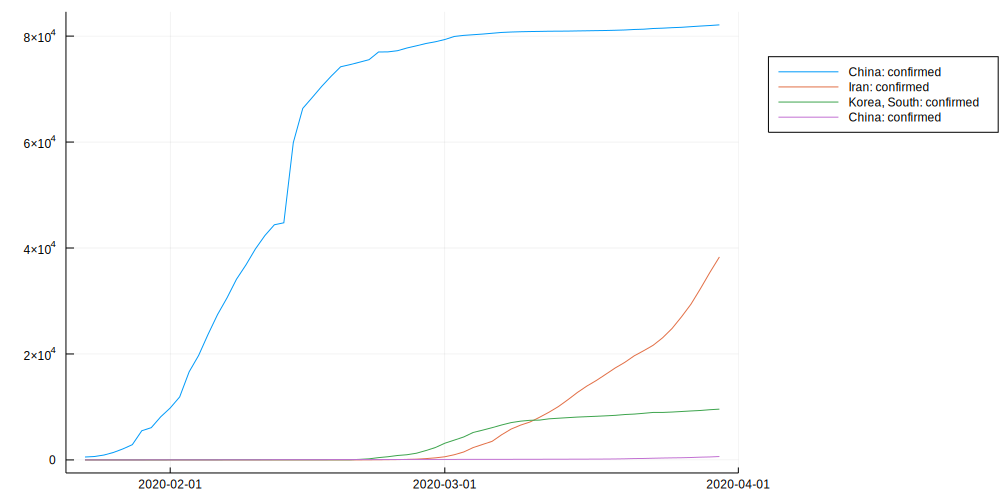

In [93]:
europe = ["China", "Iran", "Korea, South"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 1, 1))
end
plot_country!("China"; state="Hong Kong")
fig

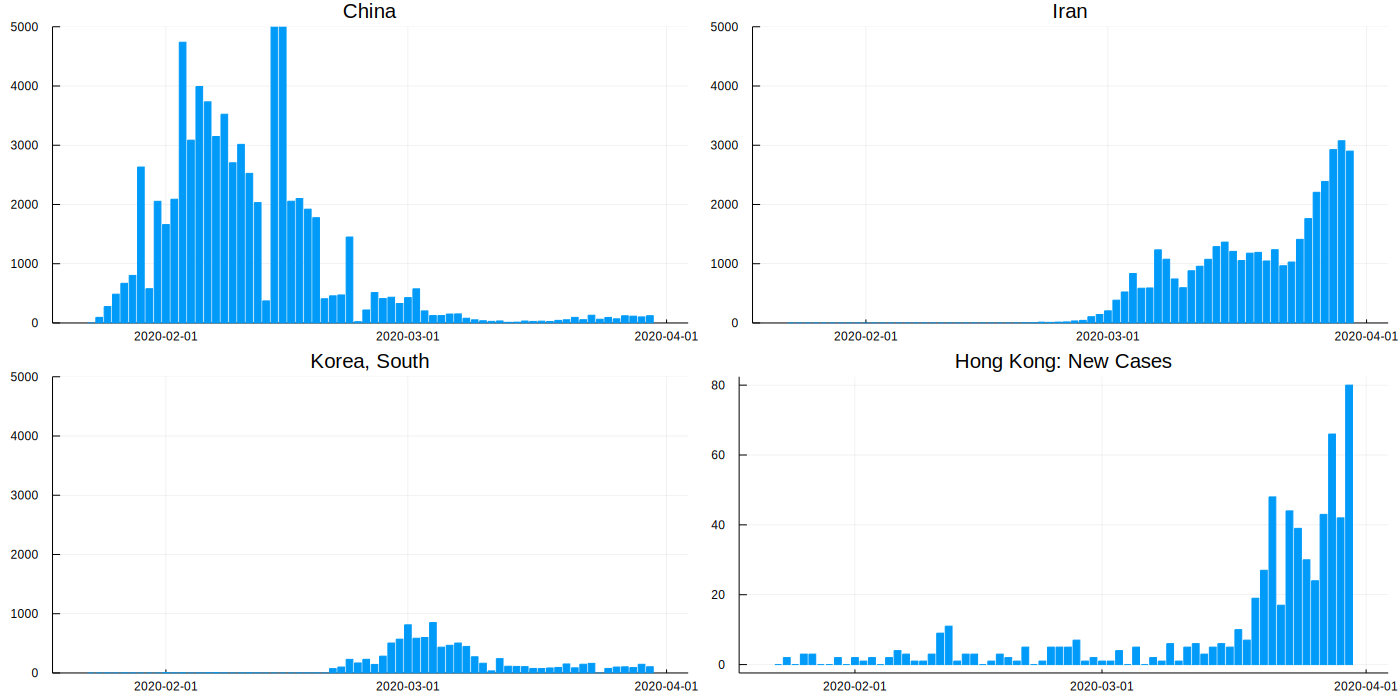

In [94]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 1, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 1, 1)), :new_cases], legend=false, linecolor=1, title=country, ylim=(0, 5000))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
push!(eu_plots, bar(country_data("China";state="Hong Kong").date, country_data("China";state="Hong Kong").new_cases, legend=false, linecolor=1, title="Hong Kong: New Cases"))
plot(eu_plots..., layout=(2, 2), size=(1400, 700))

## Europe + US
### Confirmed Cases

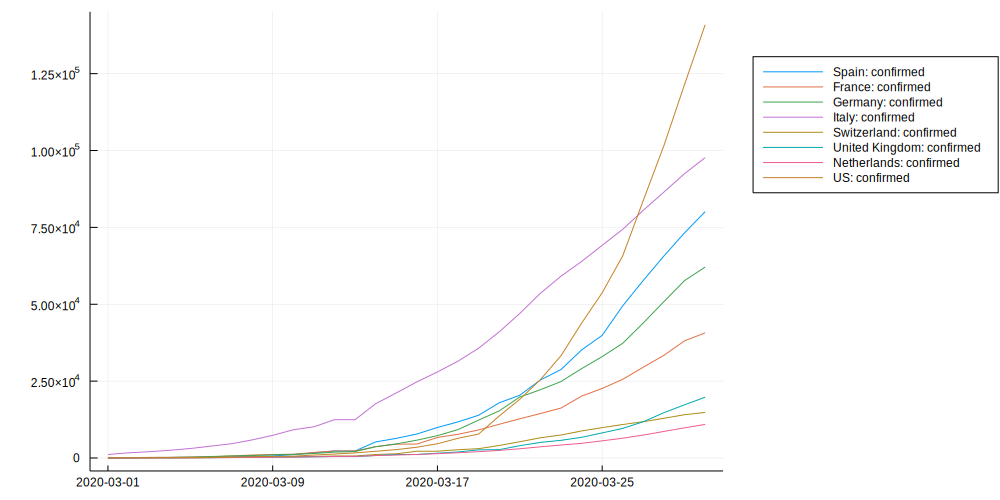

In [95]:
europe = ["Spain", "France", "Germany", "Italy", "Switzerland", "United Kingdom", "Netherlands", "US"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 3, 1))
end
fig

### Deaths

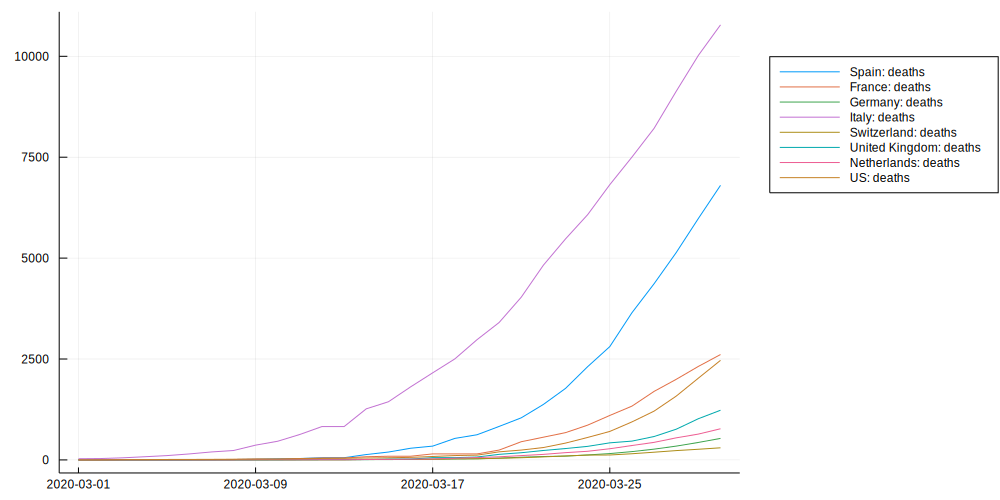

In [96]:
europe = ["Spain", "France", "Germany", "Italy", "Switzerland", "United Kingdom", "Netherlands", "US"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 3, 1), metric=:deaths)
end
fig

### New Cases per Day

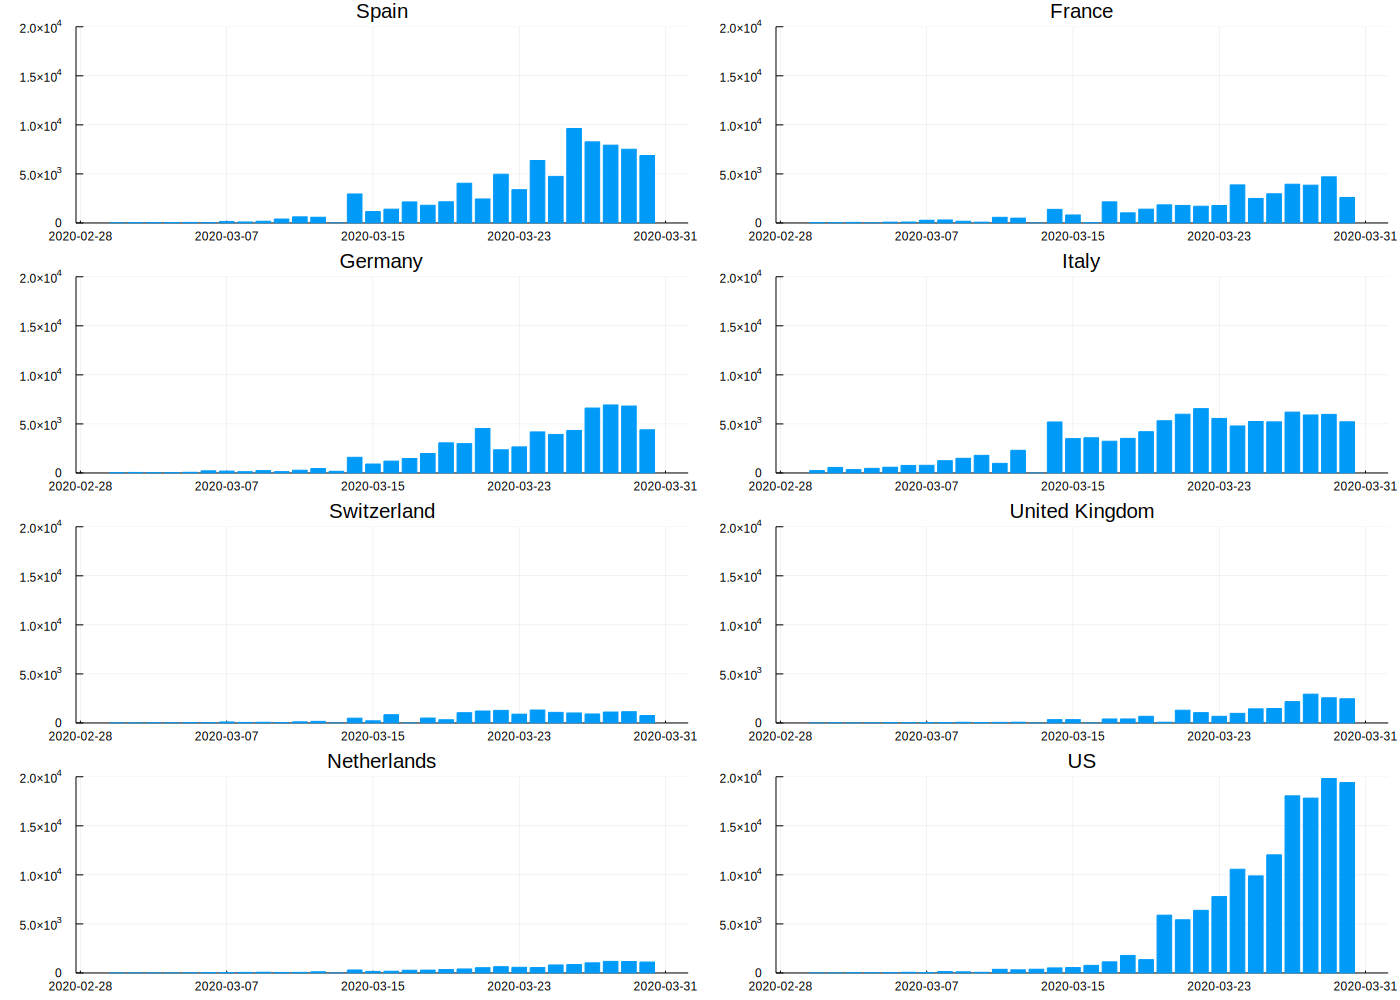

In [97]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :new_cases], legend=false, linecolor=1, title=country, ylim=(0, 20000))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
plot(eu_plots..., layout=(4, 2), size=(1400, 1000))

### New Deaths per Day

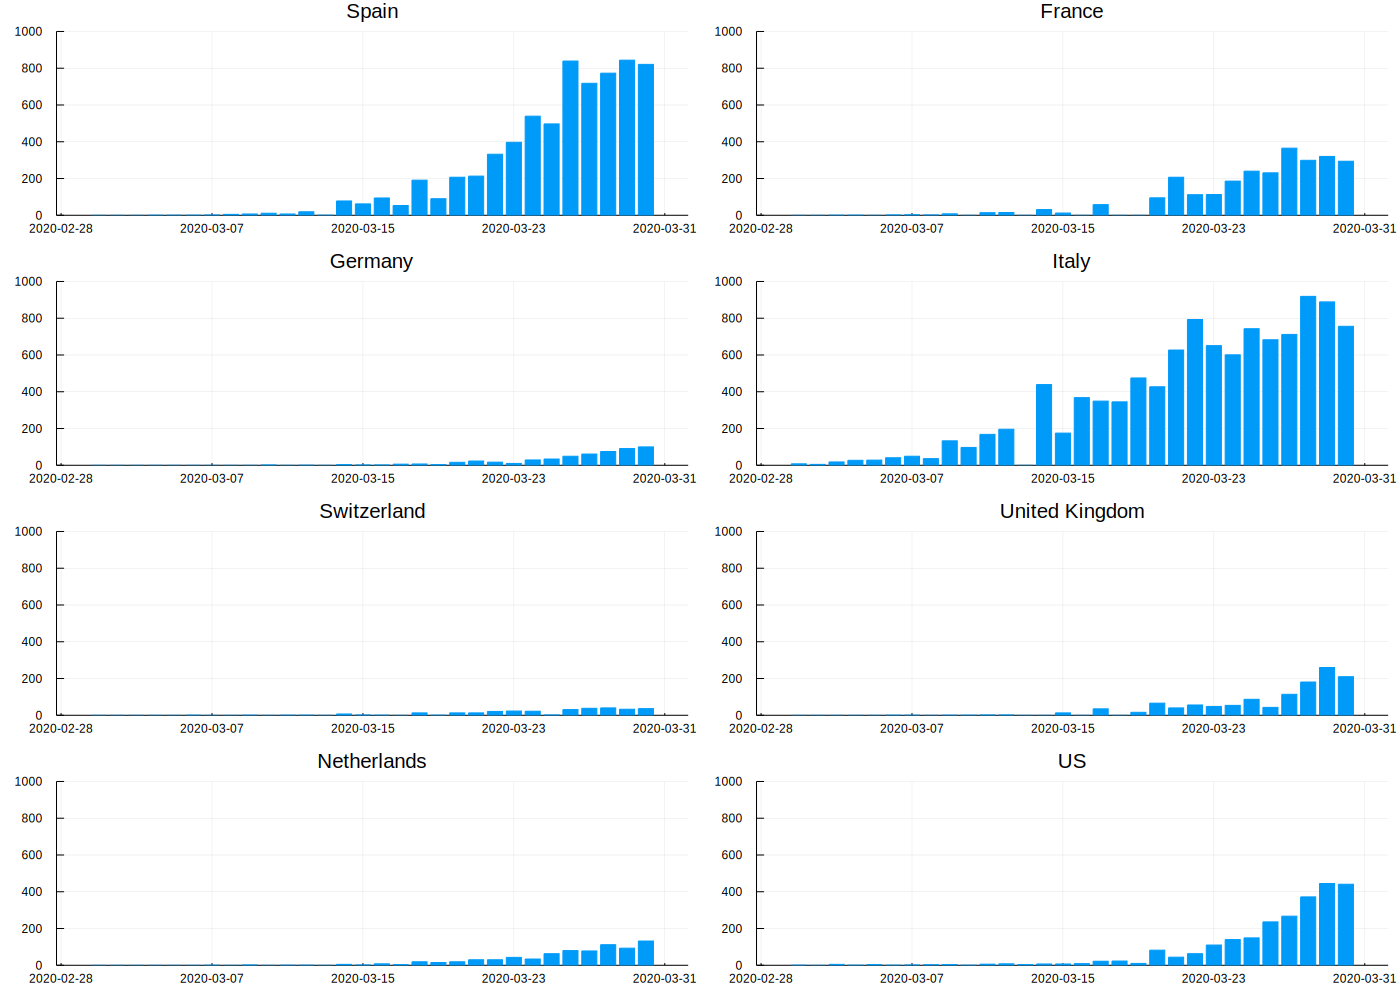

In [98]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :new_deaths], legend=false, linecolor=1, title=country, ylim=(0, 1000))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
plot(eu_plots..., layout=(4, 2), size=(1400, 1000))

## Asia (- S. Korea, China)
### Confirmed Cases

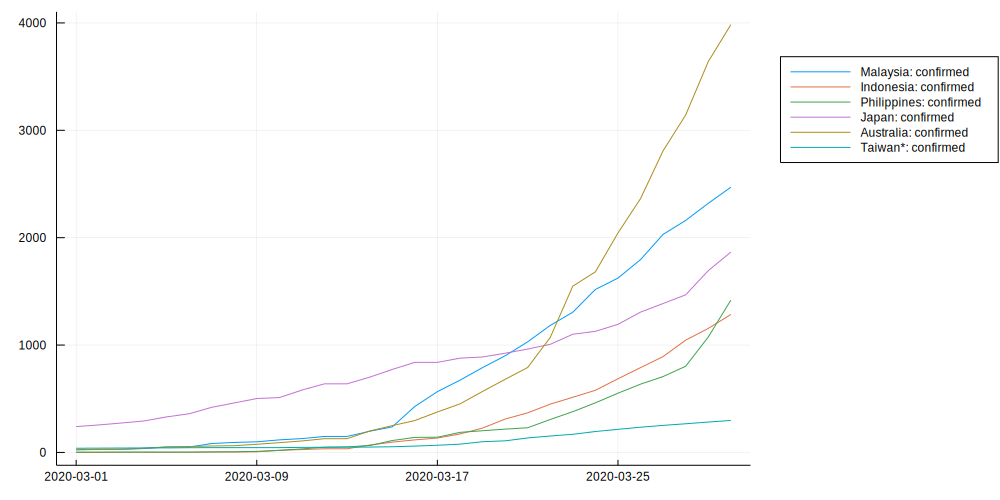

In [99]:
europe = ["Malaysia", "Indonesia", "Philippines", "Japan", "Australia", "Taiwan*"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 3, 1))
end
fig

### New Cases per Day

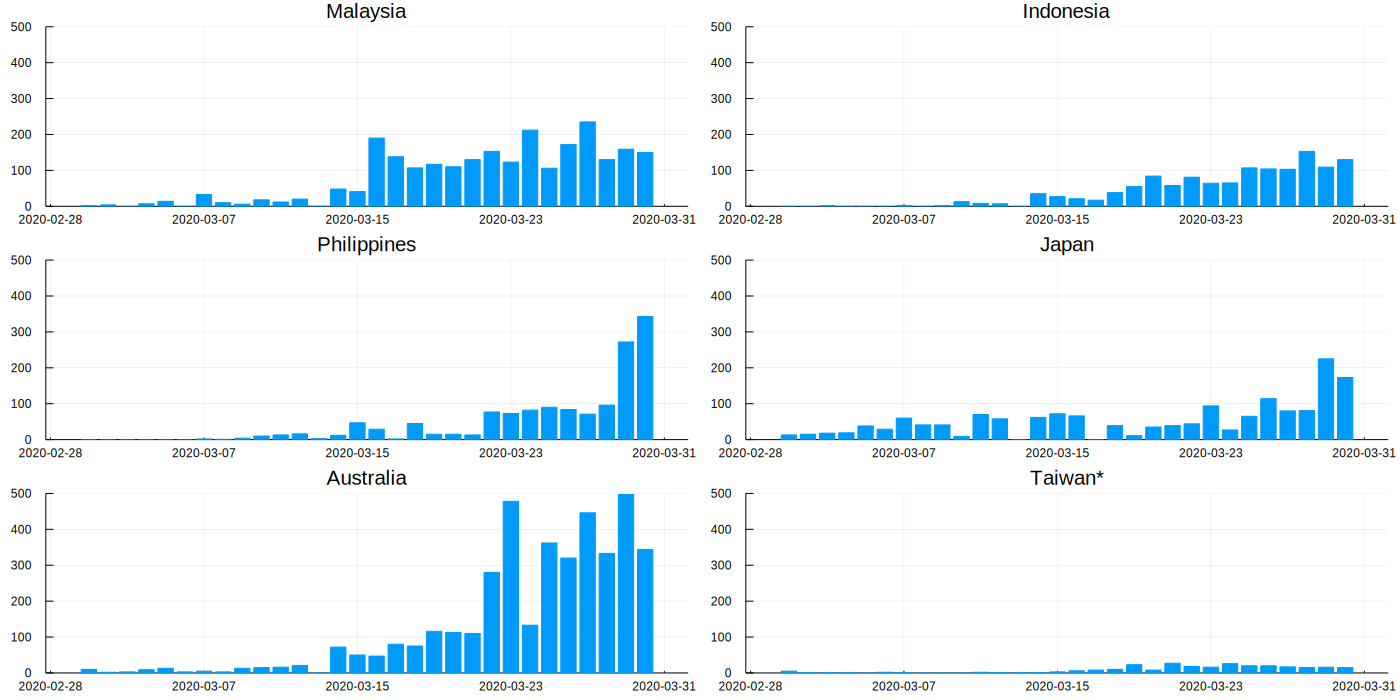

In [100]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :new_cases], legend=false, linecolor=1, title=country, ylim=(0, 500))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
plot(eu_plots..., layout=(3, 2), size=(1400, 700))

## South America
### Confirmed Cases

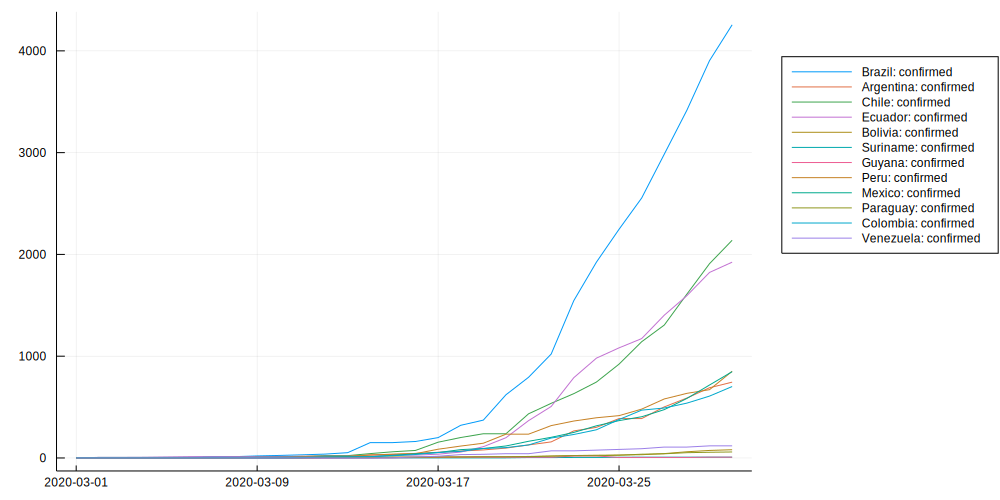

In [101]:
europe = ["Brazil", "Argentina", "Chile", "Ecuador", "Bolivia", "Suriname", "Guyana", "Peru", "Mexico", "Paraguay", "Colombia", "Venezuela"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 3, 1))
end
fig

### New Cases per Day

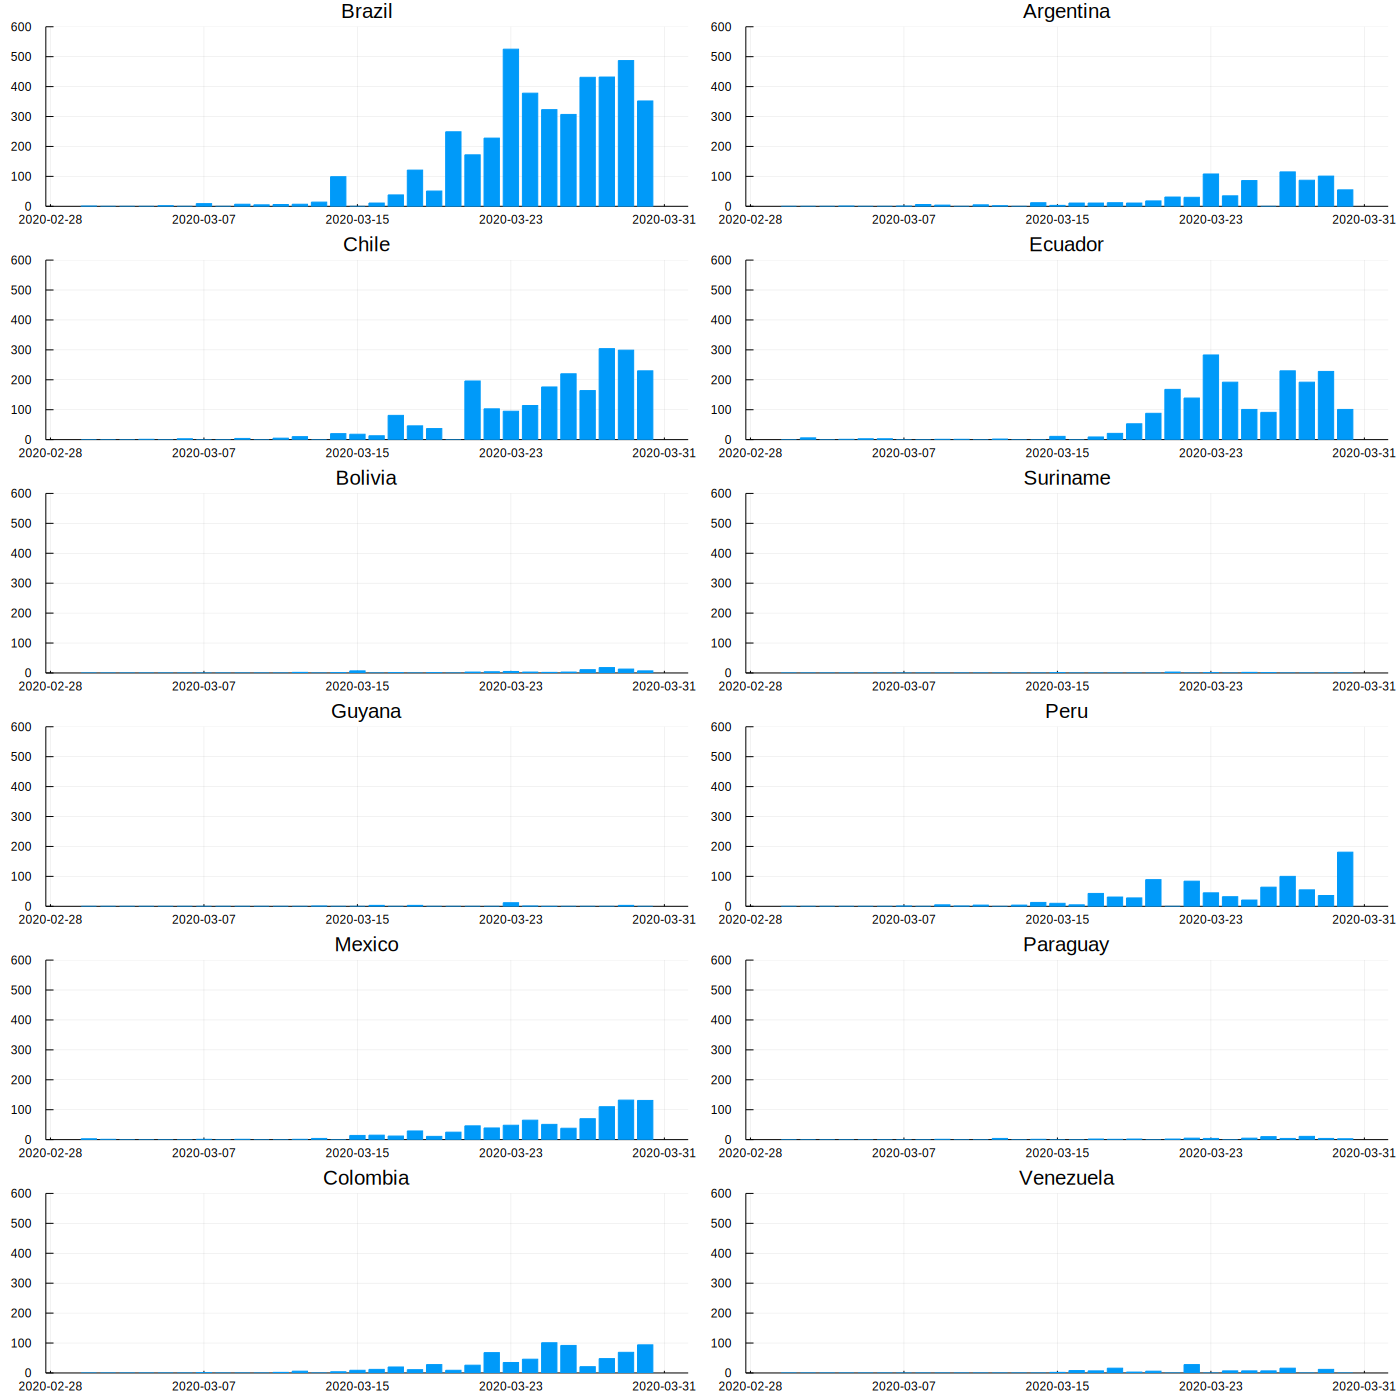

In [102]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :new_cases], linecolor=1, legend=false, title=country, ylim=(0, 600))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
plot(eu_plots..., layout=(6, 2), size=(1400, 1400))

## Hungary
## Confirmed Cases

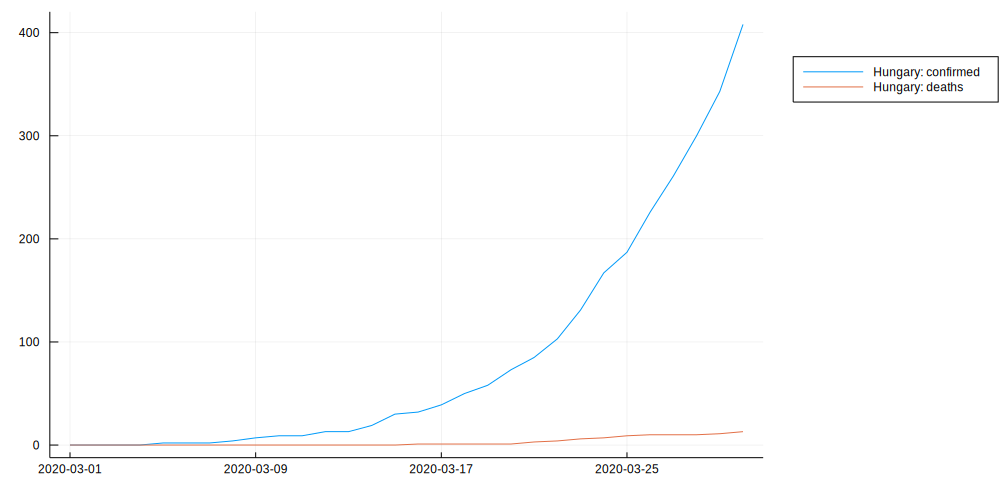

In [103]:
europe = ["Hungary"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 3, 1))
end
fig
plot_country!(europe[1]; start_date=Dates.Date(2020, 3, 1), metric=:deaths)

### New Cases per Day

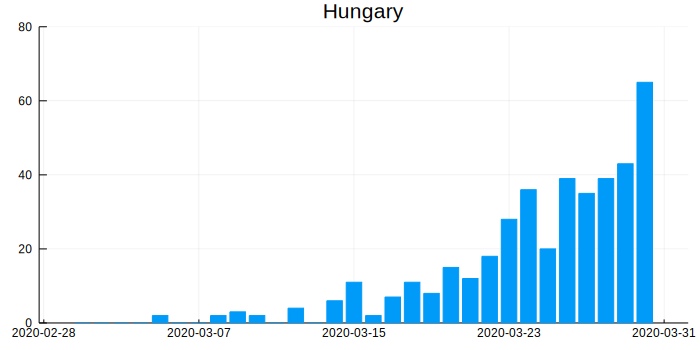

In [104]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :new_cases], legend=false, linecolor=1, title=country, ylim=(0, 80))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
plot(eu_plots..., layout=(1, 1), size=(700, 350))